In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv("train_jqd04QH.csv")
test_df = pd.read_csv("test_KaymcHn.csv")

In [3]:
train_df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1


In [4]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# Outliers_to_drop = detect_outliers(train_df,2,["Age","SibSp","Parch","Fare"])

In [5]:
missing_val = pd.concat([train_df.isnull().sum(), test_df.isnull().sum()], axis=1, keys=['Train', 'Test'])
missing_val[missing_val.sum(axis=1) > 0]
# 15% of 18300 - 2745
# 15% of 15000 - 2250

,Train,Test
gender,4098,3388.0
enrolled_university,342,279.0
education_level,457,395.0
major_discipline,2838,2393.0
experience,59,44.0
company_size,4779,4051.0
company_type,5039,4330.0
last_new_job,367,304.0


In [6]:
train_df.drop(['gender','major_discipline', 'company_size', 'company_type'],axis=1,inplace=True)

In [7]:
train_df['enrolled_university'] = train_df['enrolled_university'].replace(np.nan, 'Unknown', regex=True)
train_df['education_level'] = train_df['education_level'].replace(np.nan, 'Unknown', regex=True)
train_df['experience'] = train_df['experience'].replace(np.nan, 'Unknown', regex=True)
train_df['last_new_job'] = train_df['last_new_job'].replace(np.nan, 'Unknown', regex=True)

In [8]:
missing_val = pd.concat([train_df.isnull().sum(), test_df.isnull().sum()], axis=1, keys=['Train', 'Test'])
missing_val[missing_val.sum(axis=1) > 0]

,Train,Test
enrolled_university,0.0,279.0
education_level,0.0,395.0
experience,0.0,44.0
last_new_job,0.0,304.0
gender,NaN,3388.0
major_discipline,NaN,2393.0
company_size,NaN,4051.0
company_type,NaN,4330.0


In [9]:
from sklearn.preprocessing import LabelEncoder
label_x = LabelEncoder()

In [10]:
train_df.head()

,enrollee_id,city,city_development_index,relevent_experience,enrolled_university,education_level,experience,last_new_job,training_hours,target
0,23798,city_149,0.689,Has relevent experience,no_enrollment,Graduate,3,1,106,0
1,29166,city_83,0.923,Has relevent experience,no_enrollment,Graduate,14,1,69,0
2,46,city_16,0.910,Has relevent experience,no_enrollment,Graduate,6,2,4,0
3,18527,city_64,0.666,Has relevent experience,no_enrollment,Graduate,14,1,26,0
4,21751,city_100,0.887,No relevent experience,no_enrollment,Masters,8,2,88,1


In [11]:
train_df.iloc[:,1]=label_x.fit_transform(train_df.iloc[:,1])
train_df.iloc[:,3]=label_x.fit_transform(train_df.iloc[:,3])
train_df.iloc[:,4]=label_x.fit_transform(train_df.iloc[:,4])
train_df.iloc[:,5]=label_x.fit_transform(train_df.iloc[:,5])
train_df.iloc[:,6]=label_x.fit_transform(train_df.iloc[:,6])
train_df.iloc[:,7]=label_x.fit_transform(train_df.iloc[:,7])

In [12]:
train_df.shape

(18359, 10)

In [13]:
X=np.zeros((18359, 9))
y=np.zeros((18359, 1))
X=train_df.iloc[:,0:9]
y=train_df['target']

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=101)
X_train.shape

(12851, 9)

In [15]:
from collections import Counter

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}

#train = pd.read('train.csv')
class_weights = get_class_weights(y_train)
print(class_weights)

{0: 1.0, 1: 6.62}


In [20]:
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve

In [22]:
svc = SVC(random_state=42)
svc.fit(train_features, train_labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

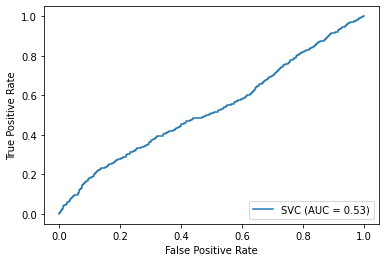

In [23]:
svc_disp = plot_roc_curve(svc, test_features, test_labels)
plt.show()

In [16]:
from xgboost import XGBClassifier

In [18]:
model = XGBClassifier()

In [19]:
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="auc", eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.598867
[1]	validation_0-auc:0.598739
[2]	validation_0-auc:0.597718
[3]	validation_0-auc:0.606664
[4]	validation_0-auc:0.608301
[5]	validation_0-auc:0.607973
[6]	validation_0-auc:0.614254
[7]	validation_0-auc:0.61211
[8]	validation_0-auc:0.6112
[9]	validation_0-auc:0.611388
[10]	validation_0-auc:0.611448
[11]	validation_0-auc:0.611264
[12]	validation_0-auc:0.611931
[13]	validation_0-auc:0.612168
[14]	validation_0-auc:0.611655
[15]	validation_0-auc:0.612138
[16]	validation_0-auc:0.611761
[17]	validation_0-auc:0.611566
[18]	validation_0-auc:0.611676
[19]	validation_0-auc:0.611496
[20]	validation_0-auc:0.610968
[21]	validation_0-auc:0.611925
[22]	validation_0-auc:0.610406
[23]	validation_0-auc:0.613893
[24]	validation_0-auc:0.613766
[25]	validation_0-auc:0.614583
[26]	validation_0-auc:0.616404
[27]	validation_0-auc:0.614979
[28]	validation_0-auc:0.614901
[29]	validation_0-auc:0.615834
[30]	validation_0-auc:0.616792
[31]	validation_0-auc:0.617186
[32]	validation_0-auc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [20]:
y_pred = model.predict(X_test)

In [22]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred))

0.5005717462037045


In [25]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
...
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.63178


In [26]:
...
# count examples in each class
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 6.571


In [27]:
# define model
model = XGBClassifier(scale_pos_weight=6.571)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.63209


In [28]:
test_df.drop(['gender','major_discipline', 'company_size', 'company_type'],axis=1,inplace=True)

test_df['enrolled_university'] = test_df['enrolled_university'].replace(np.nan, 'Unknown', regex=True)
test_df['education_level'] = test_df['education_level'].replace(np.nan, 'Unknown', regex=True)
test_df['experience'] = test_df['experience'].replace(np.nan, 'Unknown', regex=True)
test_df['last_new_job'] = test_df['last_new_job'].replace(np.nan, 'Unknown', regex=True)

test_df.iloc[:,1]=label_x.fit_transform(test_df.iloc[:,1])
test_df.iloc[:,3]=label_x.fit_transform(test_df.iloc[:,3])
test_df.iloc[:,4]=label_x.fit_transform(test_df.iloc[:,4])
test_df.iloc[:,5]=label_x.fit_transform(test_df.iloc[:,5])
test_df.iloc[:,6]=label_x.fit_transform(test_df.iloc[:,6])
test_df.iloc[:,7]=label_x.fit_transform(test_df.iloc[:,7])

test_df.head()

,enrollee_id,city,city_development_index,relevent_experience,enrolled_university,education_level,experience,last_new_job,training_hours
0,16548,73,0.448,1,0,0,20,5,15
1,12036,70,0.939,1,3,0,21,0,94
2,11061,5,0.920,1,0,0,13,0,17
3,5032,6,0.924,1,3,3,21,1,76
4,17599,105,0.830,0,3,0,16,1,65


In [29]:
test_df.shape

(15021, 9)

In [31]:
X_test=np.zeros((15021, 9))
X_test=test_df.iloc[:,0:9]

In [36]:
model.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=6.571, seed=None,
              silent=None, subsample=1, verbosity=1)

In [37]:
y_pred=model.predict(X_test)

In [38]:
submission = pd.DataFrame({ "enrollee_id": test_df["enrollee_id"],
                            "target": y_pred })
submission.to_csv('submission.csv', index=False)